# Neighbourhood Cleaning Rule


The Neighbourhood Cleaning Rule works as follows:

1) Remove noisy observations from the majority class with ENN:
- explores the 3 closest neighbours
- uses majority vote of neighbours to retain observations

2) Remove observations from the majority class if:

- they are 1 of the 3 closest neighbours to a minority sample, and
- most / all of those 3 closest neighbours are not minority, and
- the majority class has at least half as many observations as those in the minority (this can be regulated)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import NeighbourhoodCleaningRule

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Neighbourhood Cleaning Rule

[NeighbourhoodCleaningRule](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NeighbourhoodCleaningRule.html)

### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up Neighbourhood cleaning rule

ncr = NeighbourhoodCleaningRule(
    sampling_strategy='auto',# undersamples from all classes except minority
    n_neighbors=3, # explores 3 neighbours per observation
    kind_sel='all', # all neighbouring need to disagree, only applies to cleaning step
                    # alternatively, we can se this to mode, and then most neighbours
                    # need to disagree to be removed.
    n_jobs=4, # 4 processors in my laptop
    threshold_cleaning=0.5, # the threshold to evaluate a class for cleaning (used only for clearning step)
) 

# Note, the threshold_cleaning implementation by imbalanced-learn does not 
# match what was described in the original article. At the moment, it will
# only clean observations if the class has at least threshold * X.shape[0]
# number of observations

X_resampled, y_resampled = ncr.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((979, 2), (979,))

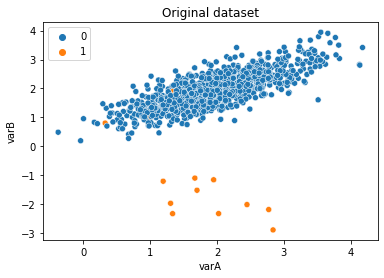

In [6]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

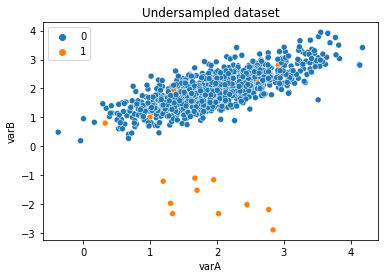

In [7]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset')
plt.show()

Note how some yellow dots can now be seen clearer as their neighbouring observations from the other class were removed from the data set.

**HOMEWORK**

- play with the parameters of the Neighbourhood cleaning Rule transformer and examine the size of the returned dataset and the distribution of the samples.

### Partially separated classes

Let's repeat the exercise in data where the classes are not so clearly separated. 

In [8]:
# create data
X, y = make_data(sep=0)

# set up Neighbourhood cleaning rule

ncr = NeighbourhoodCleaningRule(
    sampling_strategy='auto',# undersamples from all classes except minority
    n_neighbors=3, # explores 3 neighbours per observation
    kind_sel='mode', # most neighbouring need to disagree, only applies to cleaning step
                    # alternatively, we can se this to all, and then all neighbours
                    # need to disagree to be removed.
    n_jobs=4, # 4 processors in my laptop
    threshold_cleaning=0.5, # the threshold to evaluate a class for cleaning (used only for clearning step)
) 

X_resampled, y_resampled = ncr.fit_resample(X, y)

In [9]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# undersampled data

X_resampled.shape, y_resampled.shape

((951, 2), (951,))

As the classes are not so clearly distinguished, more samples were removed from the dataset.

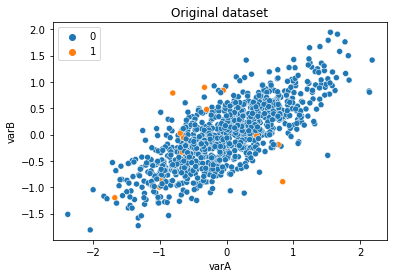

In [11]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

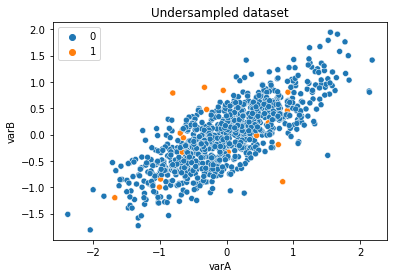

In [12]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

Notice again, that observations have been cleared from the surroundings of those of the minority class.

## Neighbourhood Cleaning Rule

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [13]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000, random_state=10)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
76689,36.51,31.00,0.22,-50.5,28.5,1775.5,0.74,1.66,-11.5,-87.5,...,1478.4,0.19,4.55,5.0,-127.0,1029.8,0.39,0.47,0.44,-1
61613,87.56,25.79,0.73,-24.0,6.5,2078.1,-0.61,1.00,7.5,-86.5,...,1549.9,0.30,-2.28,-17.0,-89.0,906.4,0.34,0.30,0.21,-1
14280,43.55,24.14,-2.09,-68.0,37.0,438.0,1.76,-0.02,-6.0,-55.0,...,-63.0,1.83,0.92,2.0,-46.0,182.5,-1.12,0.15,0.19,-1
61672,39.17,28.24,0.86,-13.0,-25.5,2326.5,0.94,0.04,-1.0,-81.5,...,1995.8,0.39,-4.37,-23.0,-54.0,188.8,2.80,0.55,0.47,-1
70728,88.80,22.52,0.89,5.0,-30.0,620.9,1.12,0.19,-4.0,-66.0,...,751.9,-0.22,-0.39,-4.0,-41.0,337.5,0.77,0.25,0.39,-1


In [14]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.9913
 1    0.0087
Name: target, dtype: float64

In [15]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

In [16]:
# set up Neighbourhood cleaning rule

ncr = NeighbourhoodCleaningRule(
    sampling_strategy='auto',# undersamples from all classes except minority
    n_neighbors=3, # explores 3 neighbours per observation
    kind_sel='mode', # all / most neighbouring need to disagree, only applies to cleaning step
    n_jobs=4, # 4 processors in my laptop
    threshold_cleaning=0.1, # the threshold to evaluate a class for cleaning (used only for clearning step)
) 

X_ncr, y_ncr = ncr.fit_resample(X_train, y_train)

In [17]:
# compare shapes

X_train.shape, X_ncr.shape

((7000, 74), (6876, 74))

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [18]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [19]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9946325648414985
Test set
Random Forests roc-auc: 0.983555705049146


In [20]:
# evaluate performance of algorithm built
# using renn undersampled dataset

run_randomForests(X_ncr,
                  X_test,
                  y_ncr,
                  y_test)

Train set
Random Forests roc-auc: 0.9907717136150235
Test set
Random Forests roc-auc: 0.9875671163932179


There was a tiny improvement in performance.

**HOMEWORK**

- Change the number of neighbours. Compare the results in terms of data size, distributions and model performance. Change also the selection method from all to mode and evaluate the same aspects.